In [2]:
%%capture
%run ./check_vol.ipynb

In [13]:
import plotly.graph_objects as go
from IPython.display import display
# import ipywidgets as widgets
import streamlit as st

In [15]:
%matplotlib inline

In [4]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'V', 'DIS']
ticker = tickers[0]
stock = yf.Ticker(ticker)
hist_data = stock.history(period="1mo", interval="5m")

In [5]:
report_date = "2026-01-26 11:00:00"
file_path = f"/Volumes/SEAGATE/crondata/{report_date[:10]}"
# expiry_date = "2026-01-30"
options_file = os.path.join(file_path, f"{ticker}_options_110002.parquet")

stock_price = hist_data[hist_data.index == f'{report_date}-05:00']
display(stock_price)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-26 11:00:00-05:00,254.809006,255.199997,254.559998,254.960007,478305,0.0,0.0


In [6]:
#combine with option prices and feed into black scholes to get implied vol (check from builtin and compare)
options_data = pd.read_parquet(options_file)
options_data_new = clean_options_data(options_data)

In [7]:
display(options_data_new.head())
display(options_data_new.tail())
print(options_data_new.shape)
print(options_data_new['expiration'].unique())

,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,expiration,TTE
8,AAPL260130C00175000,74.97,175.0,78.25,80.95,c,1.993164,10.0,2026-01-30 16:00:00,0.010959
11,AAPL260130C00190000,58.72,190.0,63.35,65.95,c,1.626467,16.0,2026-01-30 16:00:00,0.010959
13,AAPL260130C00200000,54.00,200.0,53.45,54.85,c,0.710940,17.0,2026-01-30 16:00:00,0.010959
15,AAPL260130C00210000,43.90,210.0,43.35,45.20,c,0.920899,16.0,2026-01-30 16:00:00,0.010959
16,AAPL260130C00215000,33.45,215.0,38.35,40.90,c,1.041997,46.0,2026-01-30 16:00:00,0.010959


,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,expiration,TTE
2363,AAPL281215P00195000,16.05,195.0,15.55,16.0,p,0.257881,111.0,2028-12-15 16:00:00,2.887671
2364,AAPL281215P00200000,18.00,200.0,16.90,17.3,p,0.254021,10.0,2028-12-15 16:00:00,2.887671
2365,AAPL281215P00210000,21.61,210.0,19.70,20.2,p,0.247032,48.0,2028-12-15 16:00:00,2.887671
2371,AAPL281215P00270000,43.41,270.0,43.95,44.6,p,0.206261,18.0,2028-12-15 16:00:00,2.887671
2373,AAPL281215P00290000,59.13,290.0,55.20,55.9,p,0.193734,13.0,2028-12-15 16:00:00,2.887671


(1073, 10)
<DatetimeArray>
['2026-01-30 16:00:00', '2026-02-06 16:00:00', '2026-02-13 16:00:00',
 '2026-02-20 16:00:00', '2026-02-27 16:00:00', '2026-03-06 16:00:00',
 '2026-03-20 16:00:00', '2026-04-17 16:00:00', '2026-05-15 16:00:00',
 '2026-06-18 16:00:00', '2026-07-17 16:00:00', '2026-08-21 16:00:00',
 '2026-09-18 16:00:00', '2026-11-20 16:00:00', '2026-12-18 16:00:00',
 '2027-01-15 16:00:00', '2027-06-17 16:00:00', '2027-12-17 16:00:00',
 '2028-01-21 16:00:00', '2028-03-17 16:00:00', '2028-12-15 16:00:00']
Length: 21, dtype: datetime64[ns]


In [8]:
options_theo = options_data_new.copy()
options_theo['bs_iv'] = pvv.implied_volatility.vectorized_implied_volatility(
    price=options_theo['lastPrice'].values,
    S=stock_price['Open'].values[0],
    K=options_theo['strike'].values,
    t=options_theo['TTE'].values,
    r=0.035,
    flag=options_theo['type'].values,
    model='black_scholes',
    return_as='numpy'
)

options_theo['bs_theo'] = get_theoretical_price(
    df = options_theo,
    S=stock_price['Open'].values[0],
    K='strike',
    t='TTE',
    r=0.035,
    sigma='bs_iv',
    flag='type'
)

display(options_theo.head())

/Users/stark/Desktop/Projects/Options_analysis/venv/lib/python3.13/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 7, 8, 9, 79, 80, 81, 82, 83, 84, 85, 144, 145, 181, 182, 259, 262, 263, 264, 319, 323, 324, 325, 382, 383, 385, 386, 387, 388, 439, 440, 441, 442, 446, 502, 503, 504, 505, 506, 507, 508, 509, 510, 512, 575, 576, 577, 578, 622, 623, 625, 627, 628, 667, 671, 672, 724, 755, 756, 758, 759, 760, 761, 816, 817, 877, 880, 883, 884, 924, 926, 927, 971, 972, 973, 1039, 1040, 1041]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,expiration,TTE,bs_iv,bs_theo
8,AAPL260130C00175000,74.97,175.0,78.25,80.95,c,1.993164,10.0,2026-01-30 16:00:00,0.010959,NaN,NaN
11,AAPL260130C00190000,58.72,190.0,63.35,65.95,c,1.626467,16.0,2026-01-30 16:00:00,0.010959,NaN,NaN
13,AAPL260130C00200000,54.00,200.0,53.45,54.85,c,0.710940,17.0,2026-01-30 16:00:00,0.010959,NaN,NaN
15,AAPL260130C00210000,43.90,210.0,43.35,45.20,c,0.920899,16.0,2026-01-30 16:00:00,0.010959,NaN,NaN
16,AAPL260130C00215000,33.45,215.0,38.35,40.90,c,1.041997,46.0,2026-01-30 16:00:00,0.010959,NaN,NaN


In [9]:
print(options_theo.shape)
options_theo_cleaned = options_theo.dropna()
print(options_theo_cleaned.shape)

(1073, 12)
(991, 12)


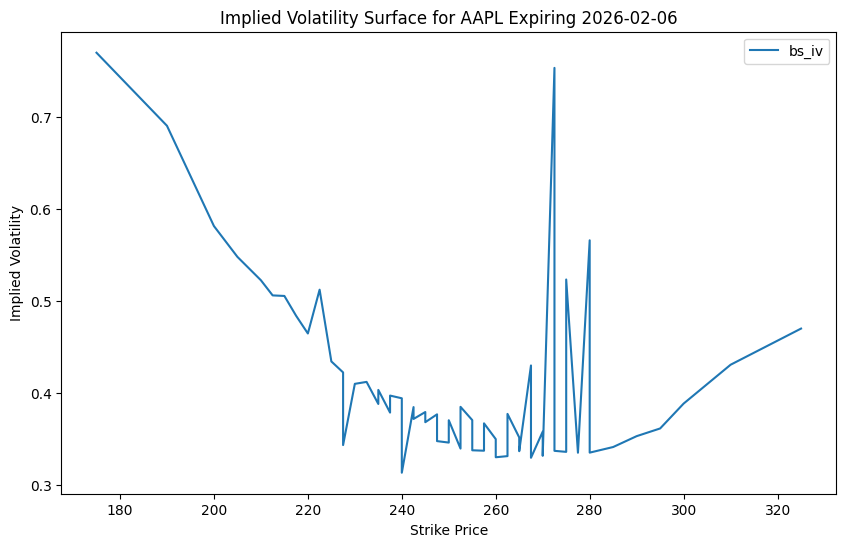

In [17]:
filtered_options = options_theo_cleaned[options_theo_cleaned['expiration'] == pd.to_datetime("2026-02-06 16:00:00")]
ax = filtered_options[['strike', 'bs_iv']].set_index('strike').sort_index().plot(
    kind='line', 
    title=f'Implied Volatility Surface for {ticker} Expiring 2026-02-06', 
    xlabel='Strike Price', 
    ylabel='Implied Volatility', 
    figsize=(10,6)
    )
# plt.show()

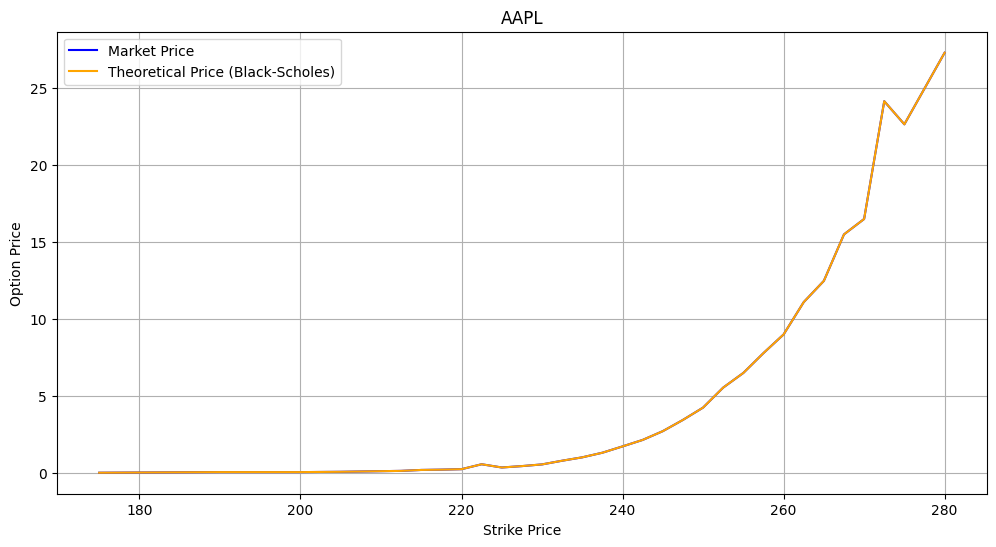

In [18]:
display_price_comparison(filtered_options[filtered_options['type'] == 'p'], 'bs_theo', 'lastPrice', ticker)

<Axes: title={'center': 'Put Implied Volatility for AAPL at Strike 230'}, xlabel='Expiration Date', ylabel='Implied Volatility'>

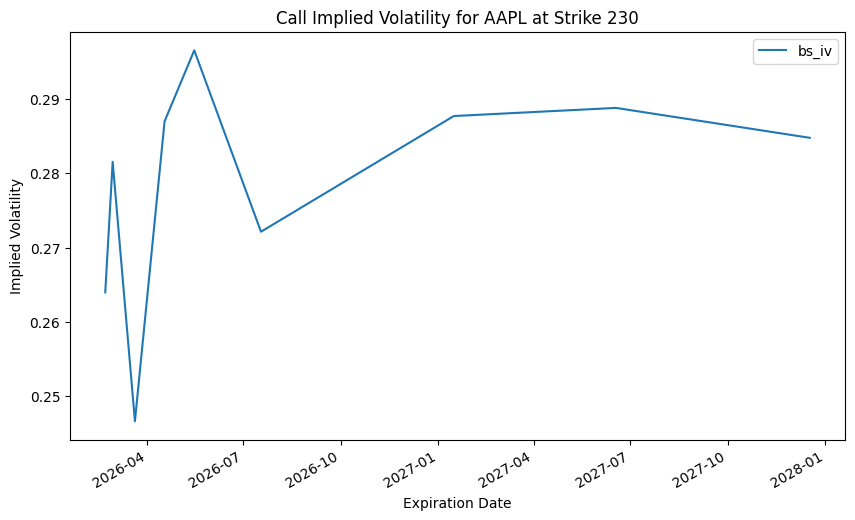

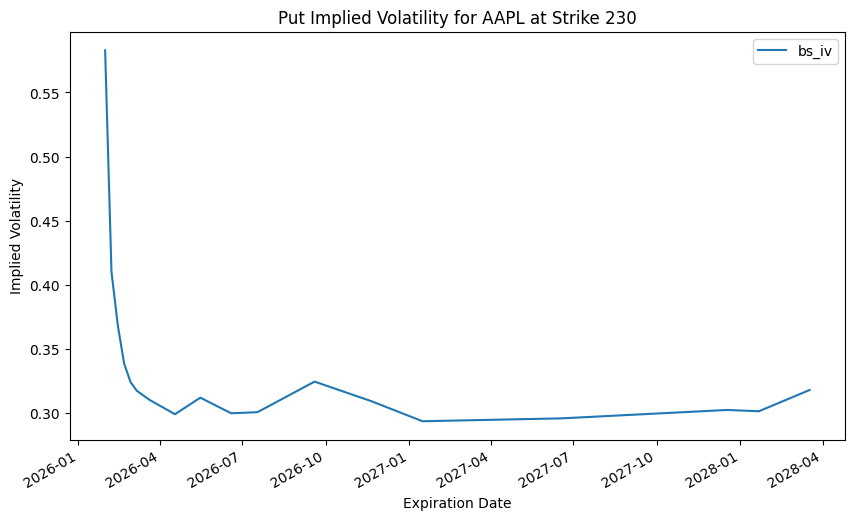

In [19]:
strike = 230
calls_at_strike = options_theo_cleaned[(options_theo_cleaned['type'] == 'c') & (options_theo_cleaned['strike'] == strike)]
puts_at_strike = options_theo_cleaned[(options_theo_cleaned['type'] == 'p') & (options_theo_cleaned['strike'] == strike)]

calls_at_strike[['expiration', 'bs_iv']].set_index('expiration').sort_index().plot(kind='line', 
                                                                                               title=f'Call Implied Volatility for {ticker} at Strike {strike}', 
                                                                                               xlabel='Expiration Date', 
                                                                                               ylabel='Implied Volatility', 
                                                                                               figsize=(10,6))
puts_at_strike[['expiration', 'bs_iv']].set_index('expiration').sort_index().plot(kind='line', 
                                                                                               title=f'Put Implied Volatility for {ticker} at Strike {strike}', 
                                                                                               xlabel='Expiration Date', 
                                                                                               ylabel='Implied Volatility', 
                                                                                               figsize=(10,6))

In [20]:
def plot_iv_surface_3d(df, TTE='TTE', strike='strike', iv='bs_iv'):
    
    surface = (
    df[['TTE', 'strike', 'bs_iv']]
    .pivot_table(values='bs_iv', index='strike', columns='TTE')
    .dropna()
    )

    fig = plt.figure(figsize=(12, 8))

    ax = fig.add_subplot(111, projection='3d')

    x, y, z = surface.columns.values, surface.index.values, surface.values
    X, Y = np.meshgrid(x, y)

    ax.set_xlabel('Time to Expiry (Years)')
    ax.set_ylabel('Strike Price')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(f'Implied Volatility Surface for {ticker}')

    ax.plot_surface(X, Y, z, cmap='turbo')

In [21]:
calls_theo_cleaned = options_theo_cleaned[(options_theo_cleaned['type'] == 'c') & (options_theo_cleaned['TTE'] < 1)]
puts_theo_cleaned = options_theo_cleaned[(options_theo_cleaned['type'] == 'p') & (options_theo_cleaned['TTE'] < 1)]

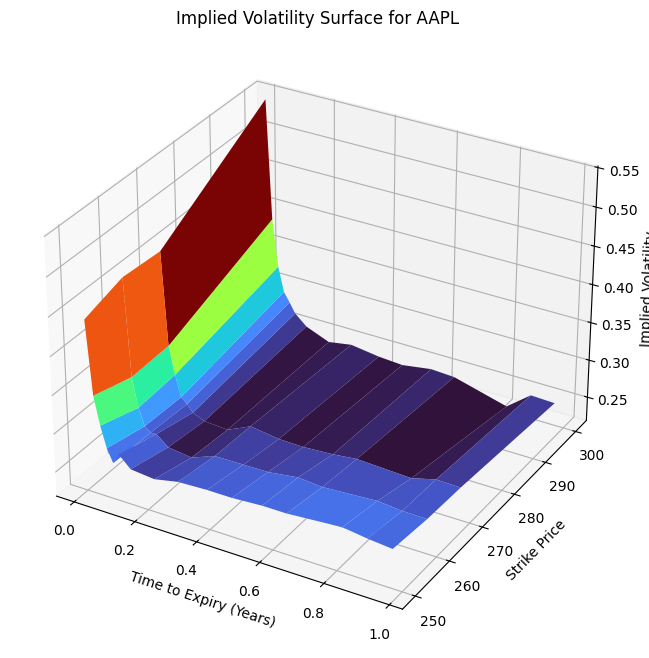

In [22]:
plot_iv_surface_3d(calls_theo_cleaned)

In [31]:
def plot_iv_surface_3d2(df, TTE='TTE', strike='strike', iv='bs_iv'):
    
    pivot = df.pivot_table(values=iv, index=strike, columns=TTE)
    
    x = pivot.columns.values
    y = pivot.index.values
    z = pivot.values
    X, Y = np.meshgrid(x, y)
    
    fig = go.Figure(
        data=[go.Surface(z=z, x=X, y=Y, colorscale='turbo')]
    )
    fig.update_layout(
        title=f'Implied Volatility Surface for {ticker}',
        scene = dict(
            xaxis_title='Time to Expiry (Years)',
            yaxis_title='Strike Price',
            zaxis_title='Black-Scholes Implied Volatility'
        ),
        autosize=True,
        width=800,
        height=800,
    )
    fig.show()

In [32]:
plot_iv_surface_3d2(calls_theo_cleaned)

In [35]:
# Create pivot table first
pivot = calls_theo_cleaned.pivot_table(values='bs_iv', index='strike', columns='TTE')

# Create meshgrid from pivot dimensions
K_grid, T_grid = np.meshgrid(pivot.columns.values, pivot.index.values)
Z_vol = pivot.values

fig = go.Figure(data=[go.Surface(
    x=K_grid,
    y=T_grid,
    z=Z_vol,
    colorscale='Viridis'
)])
fig.update_layout(
    title=f'Implied Volatility Surface for {ticker} Calls',
    scene = dict(
        xaxis_title='Time to Expiry (Years)',
        yaxis_title='Strike Price',
        zaxis_title='Black-Scholes Implied Volatility'
    ),
    autosize=True,
    width=800,
    height=800,
)
fig.show()